In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sn

import scipy.sparse
import itertools
import pickle
import warnings

from sklearn.linear_model import SGDRegressor, ElasticNet
from sklearn.preprocessing import binarize
from scipy.sparse import SparseEfficiencyWarning
from time import perf_counter
from tqdm.notebook import tqdm
from glob import glob

In [2]:
warnings.simplefilter('ignore',SparseEfficiencyWarning)

mypath = "/home/mmarzec12/data/"
savepath = "D:/0Studia/Data-Science-PW\Masters-thesis\models/slim/model_tuning/"

In [3]:
explicit = pd.read_csv(mypath+"explicit_train.csv")
validation = pd.read_csv(mypath+"leave_one_out_validation.csv")


# list with (user,item) tuples from validation set
validation_list = [(u,i) for u,i in zip(validation.user_name, validation.game_id)]
# dict with user:game key-value pairs from validation set
validation_dict = {u:i for u,i in zip(validation.user_name, validation.game_id)}

# unique games and users
unique_users = explicit.user_name.unique()
unique_games = explicit.game_id.unique()

# dictonaries to map users to unique ids and vice vers
us_to_ids = {u:i for i,u in enumerate(unique_users)}
ids_to_us = {i:u for i,u in enumerate(unique_users)}

# dictonaries to map games to unique ids and vice vers
gs_to_ids = {g:i for i,g in enumerate(unique_games)}
ids_to_gs = {i:g for i,g in enumerate(unique_games)}


implicit = pd.read_csv(mypath+"implicit_train.csv")

# filtering explicit ratings: filter ratings <6 and >=1
print(f"There is {np.sum(explicit.score <= 6)} rows with score < 6.")
explicit = explicit[explicit.score > 6]

# we join implictit and explicit rating data
joined = pd.concat([explicit, implicit])
joined = joined[["user_name", "game_id", "score"]]
# converting all interaction data to "1" 
joined = explicit
joined["score"] = 1


# creating sparse matrix with data
row = [us_to_ids[us] for us in joined.user_name]
col = [gs_to_ids[g] for g in joined.game_id]
data = joined.score

A = scipy.sparse.coo_matrix((data, (row, col)), shape=(len(unique_users), len(unique_games)))
A = A.tocsr()

There is 1362961 rows with score < 6.


In [6]:
from sklearn.linear_model import SGDRegressor
from tqdm.notebook import tqdm
from time import perf_counter
import numpy as np
import scipy.sparse
import itertools


class ParallSynSLIM():
    
    def __init__(self, l1_reg=0.001, l2_reg=0.0001):
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        
        
    def fit_one(self, A, idx_start, idx_end, alpha, l1_ratio):
        
        model = SGDRegressor(penalty='elasticnet',
                     fit_intercept=False,
                     alpha=alpha,
                     l1_ratio=l1_ratio
                     ) 
        res = []
        
        for idx in range(idx_start, idx_end):
            aj = A[:,idx].copy()
            A[:,idx] = 0
        
            model.fit(A, aj.toarray().ravel())
        
            # refill the values in data matrix
            A[:, idx] = aj
            
            # forcing non-negativity
            ws = model.coef_
            ws[ws<0] = 0
            
            # return nonzero coeffs
            for row in ws.nonzero()[0]:
                res.append((row, idx, ws[row]))
        
        return res
        
    def fit(self, A):
        
        # for sklearn function
        alpha = self.l1_reg + self.l2_reg
        l1_ratio = self.l1_reg / alpha
        
        # preparing for multiprocessing
        cpu_num = mp.cpu_count()
        n_games = A.shape[1]//10
        step = n_games / cpu_num
        idx1 = [int(i*step) for i in range(cpu_num)]
        idx2 = [int(i*step) for i in range(1, cpu_num+1)]
        if idx2[-1] != n_games:
            idx2[-1] = n_games
        
        # setting pools
        pool = mp.Pool(mp.cpu_count())
        global_start = perf_counter()
        
        result = pool.starmap(self.fit_one, 
                              [(A, idx_start, idx_end, alpha, l1_ratio) for idx_start,idx_end in zip(idx1, idx2)])
        # changing the format of the outpput to build sparse coefficient matrix
        result = list(itertools.chain(*result)) 
        row, col, data = [], [], []
        for r,c,d in result:
            row.append(r)
            col.append(c)
            data.append(d)
            
        
        self.W = scipy.sparse.coo_matrix((data, (row,col)), shape=(A.shape[1], A.shape[1]))
        
        pool.close()
        pool.join()
        
        print(f"Learning all {self.W.shape[0]} vectors took {round((perf_counter() - global_start)/60, 2)} minutes.")
        proc = 100*self.W.nnz/self.W.shape[0]**2
        print(f"In W matrix we have {self.W.nnz} nonzero elements ({round(proc,2)}%).")
        
        
    def calculate_top_k(self, A, ids_to_gs, ids_to_us, k=10):
        """
        Description:
        -----------
        Funtion for calculating list of top-k recommendations for
        all the users.
        
        
        Params:
        -----------
        A - sparse csr user-item interaction matrix
        
        ids_to_gs - dict mapping rows of matrix A
        to the game_ids (row_id:game_id)
        
        ids_to_us - dict mapping rows of matrix A
        to the user_ids (row_id:user_id)
        
        k - the length of  recommendation list
        
        
        Returns:
        ----------
        A dictionary with original user_ids as keys
        and list of item_ids as values. 
        """
        
        topk = {}
        scores = A @ self.W.tocsr()
        
        
        for uid in tqdm(range(A.shape[0])):
            r = scores[uid].toarray().flatten()
            recs = []
            known_items = set(A[uid].indices)
    
            for gid in r.argsort()[::-1]:
                if gid not in known_items:
                    recs.append(ids_to_gs[gid])
                if len(recs) >= k:
                    break
    
            topk[ids_to_us[uid]] = recs
        
        return topk

In [10]:
parall_slim = ParallSynSLIM(l1_reg=0.0001, l2_reg=0.00001)
parall_slim.fit(A)

/home/mmarzec12/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/mmarzec12/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/mmarzec12/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/mmarzec12/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/mmarzec12/anaconda3/lib/python3.9/site-packages/scipy/sparse/_inde

Learning all 2265 vectors took 1.34 minutes.
In W matrix we have 53432 nonzero elements (1.04%).


In [11]:
k=10
top10 = parall_slim.calculate_top_k(A, ids_to_gs, ids_to_us, k=10)

from metrics import Evaluator

ev = Evaluator(k=k, true=validation_list, predicted=top10)
ev.calculate_metrics()
ngcg10, err10, hr10 = ev.ndcg, ev.err, ev.hr
ngcg10, err10, hr10

  0%|          | 0/109084 [00:00<?, ?it/s]

(0.18626474568423187, 0.15181216834209024, 0.2984122327747424)

## Results

In [3]:
n_files = len(glob(savepath+"/*"))
res = []
for i in range(1,n_files+1):
    res.append(pd.read_pickle(savepath+f"/slim_{i}"))

In [4]:
res[0]

{'l1_reg': 1e-05,
 'l2_reg': 1e-05,
 'k': 10,
 'ndcg10': 0.2427573024348302,
 'err10': 0.20648184404853578,
 'hr10': 0.35918191485460743,
 'W_zeros_percentage': 4.077345535527194,
 'prediction_calc_time_seconds': 21.72697992203757}

In [5]:
resdf = pd.DataFrame(columns=["l1_reg", "l2_reg", "metric_name", "metric_value"])
rows_list = []
for r in res:
    d1 = {}
    d1["l1_reg"] = r["l1_reg"]
    d1["l2_reg"] = r["l2_reg"]
    d1["metric_name"] = "NDCG10"
    d1["metric_value"] = r["ndcg10"]
    d1["percent_nonzero"] = r["W_zeros_percentage"]
    d1["pred_time"] = r["prediction_calc_time_seconds"]
    rows_list.append(d1)
    
    d2 = {}
    d2["l1_reg"] = r["l1_reg"]
    d2["l2_reg"] = r["l2_reg"]
    d2["metric_name"] = "ERR10"
    d2["metric_value"] = r["err10"]
    d2["percent_nonzero"] = r["W_zeros_percentage"]
    d2["pred_time"] = r["prediction_calc_time_seconds"]
    rows_list.append(d2)
    
    d3 = {}
    d3["l1_reg"] = r["l1_reg"]
    d3["l2_reg"] = r["l2_reg"]
    d3["metric_name"] = "HR10"
    d3["metric_value"] = r["hr10"]
    d3["percent_nonzero"] = r["W_zeros_percentage"]
    d3["pred_time"] = r["prediction_calc_time_seconds"]
    rows_list.append(d3)

    
resdf = pd.DataFrame(rows_list)

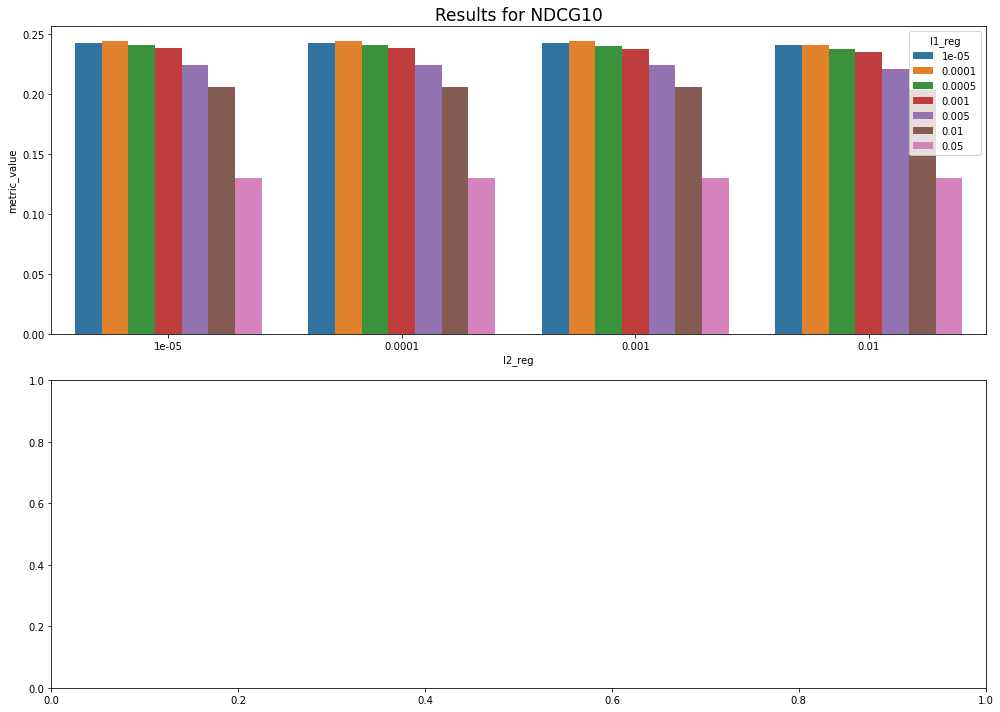

In [6]:
metrics = resdf.metric_name.unique()
fig, axes = plt.subplots(2, 1, figsize=(14,10))
axes = axes.ravel()
for i in range(len(metrics)-2):
    tmp = resdf[resdf.metric_name==metrics[i]]
    axes[i].set_title(f"Results for {metrics[i]}", fontsize=17)
    sn.barplot(y="metric_value", x="l2_reg", hue="l1_reg", data=tmp, ax=axes[i])
    
fig.tight_layout()
# fig.delaxes(axes[-1])

In [7]:
best_idx = resdf[(resdf.metric_name=="NDCG10")].metric_value.idxmax()
best_params = resdf.iloc[best_idx,:]
best_params

l1_reg                0.0001
l2_reg               0.00001
metric_name           NDCG10
metric_value         0.24418
percent_nonzero      1.72355
pred_time          21.260351
Name: 12, dtype: object

In [11]:
# save the results
with open("/home/mmarzec12/models/slim/"+"slim_best_params", "wb") as handle:
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
from sklearn.linear_model import SGDRegressor

class NormalSLIM():
    
    def __init__(self, l1_reg=0.001, l2_reg=0.0001):
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        
        
    def fit(self, A):
        self.n, self.m = A.shape
        self.W = np.zeros((A.shape[1],A.shape[1]))
        
        # for sklearn function
        alpha = self.l1_reg + self.l2_reg
        l1_ratio = self.l1_reg / alpha
        
        model = SGDRegressor(penalty='elasticnet',
                     fit_intercept=False,
                     alpha=alpha,
                     l1_ratio=l1_ratio
                     )
        
        global_start = perf_counter()
        start = perf_counter()
        
        for j in range(self.m):
            
            if (j+1) % 5 == 0:
                print(f'Learning next {5} vectors took {round((perf_counter() - start)/60, 2)} minutes.')
                start = perf_counter()
                      
            aj = A[:,j].copy()
            A[:,j] = 0
            
            model.fit(A, aj.toarray().ravel())
            
            # refill the values in data matrix
            A[:, j] = aj
            
            # non-negativity and j,j=0
            ws = model.coef_
            ws[ws<0] = 0

            
            # update weight matrix
            self.W[:,j] = ws
        
        print(f"Whole training process (learning {self.W.shape[0]} vectors) took\
        {round((perf_counter() - start)/60, 2)} minutes")

In [23]:
slim = NormalSLIM(l1_reg=0.001, l2_reg=0.0001)
slim.fit(A)

Learning next 4 vectors took 0.66 minutes.
Learning next 9 vectors took 0.9 minutes.
Learning next 14 vectors took 0.86 minutes.
Learning next 19 vectors took 0.91 minutes.
Learning next 24 vectors took 0.92 minutes.
Learning next 29 vectors took 0.89 minutes.
Learning next 34 vectors took 0.9 minutes.
Learning next 39 vectors took 0.93 minutes.
Learning next 44 vectors took 0.92 minutes.
Learning next 49 vectors took 1.0 minutes.
Learning next 54 vectors took 1.01 minutes.


KeyboardInterrupt: 